In [1]:
from google.colab import files
from PIL import Image

import scipy.signal
!pip install librosa
!pip install soundfile
import librosa
import librosa.display
import soundfile as sf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import IPython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [153]:
uploaded = files.upload()

Saving 27.jpg to 27.jpg


In [154]:
IMAGE_FILENAME = "" #@param {type: "string"}

### Parameters

In [64]:
#@title
def plot_color_gradient(cmap):
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))
    # Create figure and adjust figure height to number of colormaps
    nrows = 1
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, ax = plt.subplots(nrows=nrows, figsize=(6.4, figh))
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)


    ax.imshow(gradient, aspect='auto', cmap=cmap)
    ax.text(-0.01, 0.5, str(cmap.name), va='center', ha='right', fontsize=10,
            transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    ax.set_axis_off()

In [155]:
#@markdown Whether or not to flip the spectrogram vertically.
#@markdown If true, the bottom of your image will be interpreted as low-end frequencies.
do_flip = True #@param {type: "boolean"}

#@markdown Whether or not to do affine transform on image. (Translation as supported rn)
do_affine_transform = True #@param {type: "boolean"}

#@markdown Distance metric for color mapping
dist_metric = 'squared' #@param ["squared", "manhattan"] {type: "string"}

#@markdown X and Y translation of image
x_translate = 0 #@param {type: "integer"}
y_translate =  0#@param {type: "integer"}



#@markdown Matplotlib colormap that closest matches your image.
cmap_name = 'jet' #@param ['viridis', 'plasma', 'inferno', 'magma', 'jet'] {type: "string"}
cmap = cm.get_cmap(cmap_name)

#@markdown ---
#@markdown ### Signal processing parameters

#@markdown Max amplitude of output signal.
max_amplitude = 80 #@param {type: "integer"}

#@markdown Hop length for griffin-lim. Shorter values will shorten the sample.
hop_length = 256 #@param {type: "integer"}
sample_rate = 22050 #@param {type: "integer"}
#@markdown ---

print("Colormap visualization")
plot_color_gradient(cmap)

Colormap visualization


### Image Manipulation

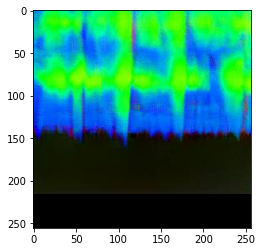

In [156]:
im = Image.open(IMAGE_FILENAME)

if do_affine_transform:
  im = im.transform(im.size, Image.AFFINE, (1, 0, x_translate, 0, 1, y_translate))

if do_flip:
  im = im.transpose(Image.FLIP_TOP_BOTTOM)

im_arr = np.asarray(im, dtype='float32')
plt.imshow(im_arr.astype('int'))

### Spectrogram processing

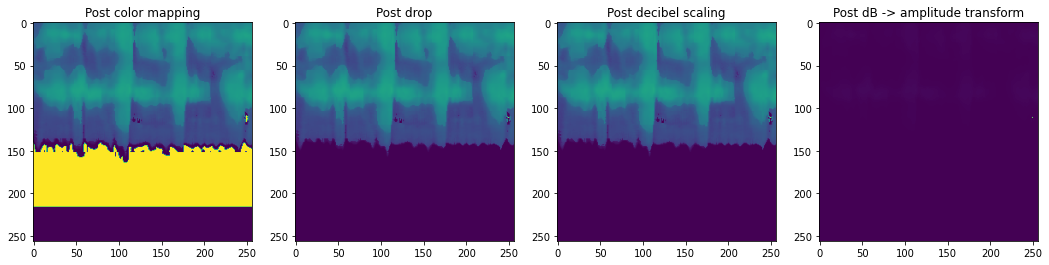

In [157]:
#@title
colrange = [0, 255]
r = np.linspace(colrange[0], colrange[1], 256)
norm = matplotlib.colors.Normalize(colrange[0], colrange[1])
mapvals = cmap(norm(r))[:, :3] # there are 3 channels: r,g,b

def get_value_from_cm(color):
    color = np.array(color) / 255.

    dist = None
    if dist_metric == 'manhattan':
      dist = np.abs(mapvals - color)
    elif dist_metric == 'squared':
      dist = (mapvals - color)**2
    else:
      dist = (mapvals - color)**2

    distance = np.sum(dist, axis=1)
    return r[np.argmin(distance)]

def min_max_scale(a, b, sig):
    return a + ((sig - np.min(sig)) * (b - a)) / (np.max(sig) - np.min(sig))

fig, ax = plt.subplots(1, 4, figsize=(18, 6))

# Map colors in image to values
processed = np.apply_along_axis(get_value_from_cm, axis=2, arr=im_arr)

ax[0].set_title('Post color mapping')
ax[0].imshow(processed)

# Drop max values. Happens with certain color scales mapping black colors to 255.
processed[processed == 255.] = 0.

ax[1].set_title('Post drop')
ax[1].imshow(processed)

# Scale values to represent an appropriate decibel range.
processed = min_max_scale(-max_amplitude, 2e-5, processed)

ax[2].set_title('Post decibel scaling')
ax[2].imshow(processed)

# Transform to amplitudes since this is what gets consumed by griffin-lim.
processed = librosa.db_to_amplitude(processed, ref=np.abs(np.min(processed)))
#processed = np.abs(processed)

ax[3].set_title('Post dB -> amplitude transform')
ax[3].imshow(processed)

### Signal transformation

In [158]:
audio_signal = librosa.core.spectrum.griffinlim(processed, hop_length=hop_length)

In [159]:
# Normalize audio signal so your ears don't get obliterated instantly
audio_signal = audio_signal * (1 / np.max(np.abs(audio_signal)))

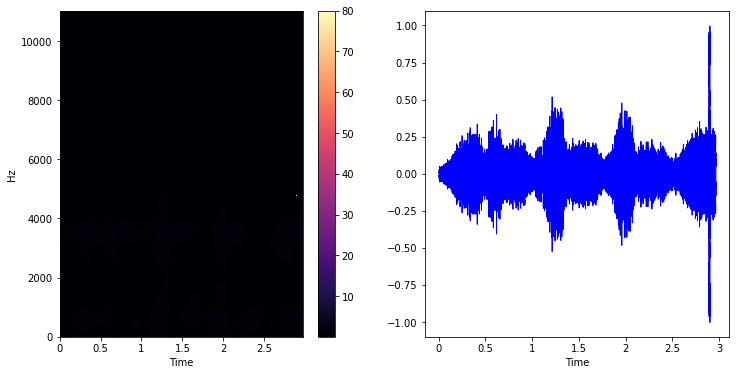

In [160]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
img = librosa.display.specshow(processed,
                               y_axis='linear', x_axis='time', ax=ax[0], hop_length=hop_length)
librosa.display.waveshow(audio_signal, sr=sample_rate, color='b', ax=ax[1])

fig.colorbar(img, ax=ax[0])

In [161]:
sf.write('result.wav', audio_signal, sample_rate, 'PCM_24')
IPython.display.Audio('result.wav')